In [25]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [26]:
import datetime
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tqdm import tqdm

In [27]:
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam

In [28]:
# import cv2
# import urllib
# import requests
# import PIL.Image

# from bs4 import BeautifulSoup

In [29]:
# #downloading ship synset
# ship_page = requests.get("http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n03095699")
# ship_soup = BeautifulSoup(ship_page.content, "html.parser")

# #downloading bike synset:
# bike_page = requests.get("http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n03792782")
# bike_soup = BeautifulSoup(bike_page.content, "html.parser")

# ship_soup_str = str(ship_soup)
# ship_soup_split_url = ship_soup_str.split("\r\n")

# bike_soup_str = str(bike_soup)
# bike_soup_split_url = bike_soup_str.split("\r\n")

In [30]:
# os.mkdir('./content')
# os.mkdir('./content/train')
# os.mkdir('./content/train/ships')
# os.mkdir('./content/train/bikes')
# os.mkdir('./content/validation')
# os.mkdir('./content/validation/ships')
# os.mkdir('./content/validation/bikes')

In [31]:
# print("le: ", len(bike_soup_split_url))

In [32]:
# image_rows, image_cols = 32, 32

# input_shape = (image_rows, image_cols, 3)

# def url_to_image(url):
#     resp = urllib.request.urlopen(url)
#     image = np.asarray(bytearray(resp.read()), dtype="uint8")
#     image = cv2.imdecode(image, cv2.IMREAD_COLOR)
#     return image

# n_training_images = 100

# #train images for ship
# for progress in tqdm(range(n_training_images)):
#     if not ship_soup_split_url[progress] == None:
#         try:
#             I = url_to_image(ship_soup_split_url[progress])
#             if len(I.shape) == 3:
#                 save_path = "./content/train/ships/img" + str(progress) + ".jpeg"
#                 cv2.imwrite(save_path, I)
#         except:
#             None

# #train images for bikes
# for progress in tqdm(range(n_training_images)):
#     if not bike_soup_split_url[progress] == None:
#         try:
#             I = url_to_image(bike_soup_split_url[progress])
#             if len(I.shape) == 3:
#                 save_path = "./content/train/bikes/img" + str(progress) + ".jpeg"
#                 cv2.imwrite(save_path, I)
#         except:
#             None

# #validation images for ships
# for progress in tqdm(range(50)):
#     if not ship_soup_split_url[n_training_images+progress] == None:
#         try:
#             I = url_to_image(ship_soup_split_url[n_training_images+progress])
#             if len(I.shape) == 3:
#                 save_path = "./content/validation/ships/img" + str(progress) + ".jpeg"
#                 cv2.imwrite(save_path, I)
#         except:
#             None


# #validation images for bikes
# for progress in tqdm(range(50)):
#     if not bike_soup_split_url[n_training_images+progress] == None:
#         try:
#             I = url_to_image(bike_soup_split_url[n_training_images+progress])
#             if len(I.shape) == 3:
#                 save_path = "./content/validation/bikes/img" + str(progress) + ".jpeg"
#                 cv2.imwrite(save_path, I)
#         except:
#             None

In [33]:
#defining model

class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(
            96, 
            kernel_size=(11, 11), 
            strides=4, 
            padding="valid", 
            activation="relu", 
            input_shape=input_shape,
            kernel_initializer="he_normal"
        ))
        
        self.add(MaxPooling2D(
            pool_size=(3, 3),
            strides = (2, 2),
            padding = "valid",
            data_format = None
        ))

        self.add(Conv2D(
            256,
            kernel_size=(5, 5),
            strides=1,
            padding="same",
            activation="relu",
            kernel_initializer="he_normal"
        ))

        self.add(MaxPooling2D(
            pool_size=(3, 3),
            strides = (2, 2),
            padding="valid",
            data_format=None
        ))

        self.add(Conv2D(
            384,
            kernel_size=(3, 3),
            strides=1,
            padding="same",
            activation="relu",
            kernel_initializer="he_normal"
        ))

        self.add(Conv2D(
            384,
            kernel_size=(3, 3),
            strides=1,
            padding="same",
            activation="relu",
            kernel_initializer="he_normal"
        ))

        self.add(Conv2D(
            256,
            kernel_size=(3, 3),
            strides=1,
            padding="same",
            activation="relu",
            kernel_initializer="he_normal"
        ))

        self.add(MaxPooling2D(
            pool_size=(3, 3),
            strides=(2, 2),
            padding="valid",
            data_format=None
        ))

        self.add(Dropout(0.5))
        self.add(Flatten())
        self.add(Dropout(0.5))
        self.add(Dense(4096, activation="relu"))
        self.add(Dense(4096, activation="relu"))
        self.add(Dense(1000, activation="relu"))
        self.add(Dense(num_classes, activation="softmax"))

        self.compile(
            optimizer=Adam(0.001),
            loss = 'categorical_crossentropy',
            metrics=["accuracy"]
        )


In [34]:
num_classes = 3

model = AlexNet((227, 227, 3), num_classes)

epochs = 50
batch_size = 32

train_dir = "/home/abhinav/Documents/Work/Hobby/Datasets/Imagenet/synsets"
valid_dir = "/home/abhinav/Documents/Work/Hobby/Datasets/Imagenet/valid_synsets"

Image_height = 227
Image_width = 227

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (Image_height, Image_width),
    color_mode="rgb",
    batch_size=batch_size,
    seed=1,
    shuffle=True,
    class_mode="categorical"
)

valid_datagen = ImageDataGenerator(
    rescale=1./255
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(Image_height, Image_width),
    color_mode="rgb",
    batch_size=batch_size,
    seed=7,
    shuffle=True,
    class_mode="categorical"
)

train_num = train_generator.samples
valid_num = valid_generator.samples

Found 3605 images belonging to 3 classes.
Found 264 images belonging to 3 classes.


In [35]:
model_dir = "/home/abhinav/Documents/Work/Hobby/Models/myalexnet.h5"

In [36]:
# Has to be executed only once
# os.mkdir("./logs")
# os.mkdir("./logs/fit")

In [37]:
log_dir = "./logs/fit" + datetime.datetime.now().strftime("%d%m%Y-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callbacks_list = [tensorboard_callback]

model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=train_num//batch_size,
    validation_data=valid_generator,
    validation_steps=valid_num//batch_size,
    callbacks=callbacks_list,
    verbose=1
)

model.summary()

Epoch 1/50


2024-07-16 04:06:57.288613: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inalex_net_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-07-16 04:07:02.414667: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 750.91MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-16 04:07:02.509753: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 750.91MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


101/112 [==========================>...] - ETA: 5s - loss: 2.4284 - accuracy: 0.5118

2024-07-16 04:08:02.655002: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 710.40MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-07-16 04:08:02.724263: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 710.40MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


112/112 [==============================] - 76s 570ms/step - loss: 2.2759 - accuracy: 0.5234 - val_loss: 1.0135 - val_accuracy: 0.4414
Epoch 2/50
112/112 [==============================] - 62s 552ms/step - loss: 0.7215 - accuracy: 0.6739 - val_loss: 0.9721 - val_accuracy: 0.5898
Epoch 3/50
112/112 [==============================] - 58s 513ms/step - loss: 0.5835 - accuracy: 0.7632 - val_loss: 0.6931 - val_accuracy: 0.7305
Epoch 4/50
112/112 [==============================] - 57s 506ms/step - loss: 0.5200 - accuracy: 0.7867 - val_loss: 0.6206 - val_accuracy: 0.7305
Epoch 5/50
112/112 [==============================] - 65s 576ms/step - loss: 0.4807 - accuracy: 0.8111 - val_loss: 0.7133 - val_accuracy: 0.7266
Epoch 6/50
112/112 [==============================] - 76s 679ms/step - loss: 0.4343 - accuracy: 0.8424 - val_loss: 0.6765 - val_accuracy: 0.7461
Epoch 7/50
112/112 [==============================] - 72s 643ms/step - loss: 0.3860 - accuracy: 0.8553 - val_loss: 0.3185 - val_accuracy: 0.8

In [38]:
model.summary()

Model: "alex_net_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 27, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 384)       1

In [39]:
model.save(model_dir)

/home/abhinav/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


x_valid:  [[[[0.9215687  0.35686275 0.7019608 ]
   [0.9215687  0.35686275 0.7019608 ]
   [0.92549026 0.36078432 0.7058824 ]
   ...
   [0.9058824  0.34117648 0.6862745 ]
   [0.9176471  0.3529412  0.69803923]
   [0.9176471  0.3529412  0.69803923]]

  [[0.9215687  0.35686275 0.7019608 ]
   [0.9215687  0.35686275 0.7019608 ]
   [0.92549026 0.36078432 0.7058824 ]
   ...
   [0.9058824  0.34117648 0.6862745 ]
   [0.9176471  0.3529412  0.69803923]
   [0.9176471  0.3529412  0.69803923]]

  [[0.9333334  0.36862746 0.7137255 ]
   [0.9333334  0.36862746 0.7137255 ]
   [0.92549026 0.36078432 0.7058824 ]
   ...
   [0.9176471  0.3529412  0.69803923]
   [0.9176471  0.3529412  0.69803923]
   [0.9176471  0.3529412  0.69803923]]

  ...

  [[0.82745105 0.21960786 0.5882353 ]
   [0.82745105 0.21960786 0.5882353 ]
   [0.8352942  0.227451   0.59607846]
   ...
   [0.78823537 0.19607845 0.56078434]
   [0.7803922  0.18823531 0.5529412 ]
   [0.7803922  0.18823531 0.5529412 ]]

  [[0.8352942  0.227451   0.5960784

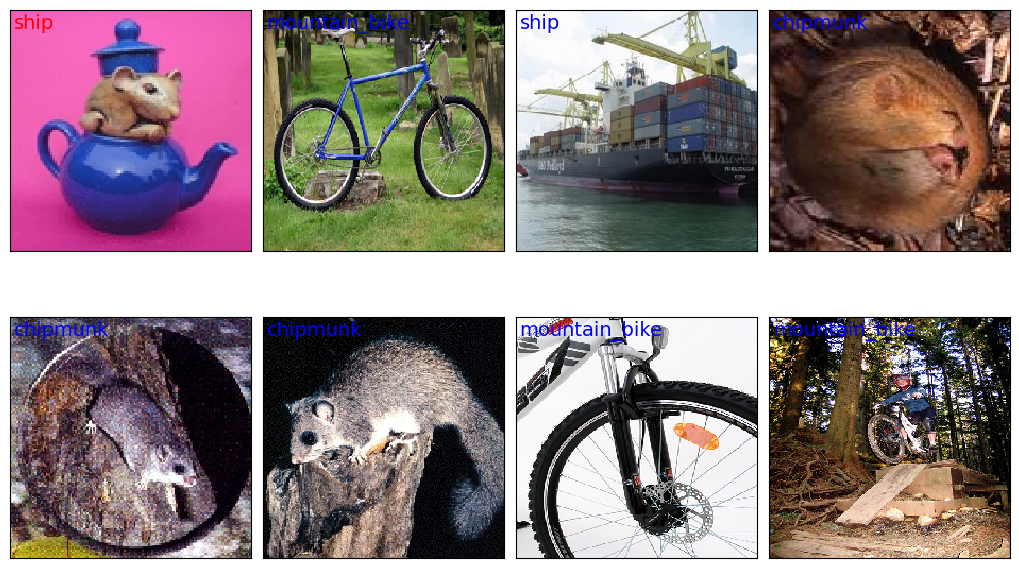

In [40]:
#predictions

class_names = ['chipmunk', 'mountain_bike', 'ship']

x_valid, label_batch = next(iter(valid_generator))
print("x_valid: ", x_valid)
print("label_batch: ", label_batch)

predict_x = model.predict(x_valid)
print("predict_x: ", predict_x)
prediction_values = np.argmax(predict_x,axis=1)
print("prediction_values", prediction_values)

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(8):
    ax = fig.add_subplot(2, 4, i+1, xticks=[], yticks=[])
    ax.imshow(x_valid[i, :], cmap=plt.cm.gray_r, interpolation='nearest')
    if prediction_values[i] == np.argmax(label_batch[i]):
        print("label_batch[i]: ", label_batch[i])
        print("prediction_values[i]:  is the same as np.argmax(label_batch[i])", prediction_values[i])
        print("class_names: ", class_names)
        ax.text(3, 17, class_names[prediction_values[i]], color='blue', fontsize=14)
    else:
        ax.text(3, 17, class_names[prediction_values[i]], color='red', fontsize=14)